In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA, KernelPCA
import optuna

import sys
sys.path.append("../") # go to parent dir

from src.debiasing import DebiasingPCA, DebiasingKPCA, NumpyDebiasingKernelPCA
from src.debiasing.utils import get_design_matrix

In [2]:
data = pd.read_csv("../data/CoLA/mixed_dev_embeddings.tsv", sep="\t")
data = data.sort_values(by='defining set id')
X = data.iloc[:, 3:771].to_numpy()
X_index = data['defining set id'].to_numpy()

Text(0.5, 0, 'the number of components')

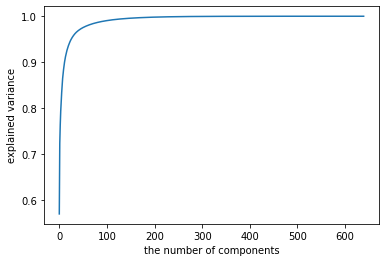

In [3]:
# data visualization
eigvals = PCA().fit(X).explained_variance_
explained_var = np.cumsum(eigvals) / np.sum(eigvals)
plt.plot(explained_var)
plt.ylabel('explained variance')
plt.xlabel('the number of components')

# PCA debiasing

In [4]:
debiaser = DebiasingPCA(n_components=3)
debiaser.fit(X, X_index)
X_debiased = debiaser.debias(X)

In [5]:
np.linalg.norm(X_debiased)

327.869283571445

# Kernel PCA debiasing (by kernel ridge pre-imaging)

In [6]:
np.linalg.norm(X)

426.1726765040533

### Unsuccessful case (Learn pre-image of bias subspace by min || Phi(w) - Proj (Phi(w))||)

In [9]:
debiaser = NumpyDebiasingKernelPCA(n_components=3, kernel="rbf")
debiaser.fit(X, X_index)
X_debiased = debiaser.debias(X)

In [10]:
np.linalg.norm(X_debiased)

63.74915566837997

In [11]:
np.linalg.norm(debiaser.transform(X))

5.705028890378092

### OK case (Learn pre-image of bias subspace by min || Phi(w - m) - Proj (Phi(w - m))||)

In [12]:
DX = get_design_matrix(X_index)
X_diff = DX @ X
kpca = KernelPCA(n_components=3, kernel="rbf", gamma=0.14, fit_inverse_transform=True)
kpca.fit(X_diff)
X_bias = kpca.inverse_transform(kpca.transform(X))
X_debiased = X - X_bias

In [13]:
np.linalg.norm(X_debiased)

425.87166574536064

# Kernel PCA (optimization based)

### OK case (Learn pre-image of bias subspace by min || Phi(w) - Proj (Phi(w))||)

In [20]:
debiaser = DebiasingKPCA(n_components=3)
debiaser.fit(X, X_index)
X_tr = debiaser.transform(X)
X_debiased = debiaser.debias(X[:320])
print()

In [21]:
np.linalg.norm(X_debiased)

361.85165918282274

# Make sure that implementation is consistent with sklearn's KernelPCA

Minor difference in the reconstruction error is due to the mean centering in the KernelPCA.

In [15]:
from sklearn.datasets import load_digits
from sklearn.decomposition import KernelPCA, PCA
toy_data = load_digits()['data']
x_train = toy_data[:1300]
x_test = toy_data[1300:]

In [27]:
m = KernelPCA(n_components=3, kernel='rbf', gamma=1/768)
m.fit(x_train[:20])
x_tr = m.transform(x_test)

In [28]:
# x_tr

In [29]:
m.alphas_

array([[-0.13034411,  0.6133088 , -0.03667619],
       [-0.10721129, -0.29394957, -0.08533229],
       [-0.12324455, -0.1486849 , -0.20774017],
       [ 0.43546054, -0.03745504,  0.17594614],
       [-0.27961513, -0.08845386,  0.36925729],
       [ 0.39954949,  0.1018399 ,  0.13015318],
       [-0.24219356, -0.10767066,  0.3568993 ],
       [-0.05737064, -0.0724354 , -0.35598462],
       [ 0.06810921,  0.02810457, -0.07460732],
       [ 0.18617942,  0.18394585,  0.02353674],
       [-0.23987768,  0.56633606,  0.00077173],
       [-0.07716265, -0.23649488, -0.13471458],
       [ 0.04533376, -0.08729738, -0.06245502],
       [ 0.35772484, -0.01551562, -0.01691075],
       [-0.27478669, -0.01717164,  0.25607278],
       [-0.02403105, -0.07915717, -0.29010805],
       [-0.15273732, -0.22446805,  0.32024181],
       [-0.11817037, -0.04037529, -0.25826709],
       [-0.01283742, -0.03179416, -0.33464836],
       [ 0.34722522, -0.01261155,  0.22456547]])

In [30]:
m.lambdas_

array([1.5464397 , 1.40916898, 1.23258586])

In [31]:
m._get_kernel(x_test[:2], x_test[:2])

array([[1.        , 0.01105129],
       [0.01105129, 1.        ]])

In [32]:
np.exp(- 1./768 * np.sum((x_test[:2, None, :] - x_test[None, :2, :])**2, axis=-1))

array([[1.        , 0.01105129],
       [0.01105129, 1.        ]])

In [33]:
m_ = TorchDebiasingKernelPCA(n_components=3, kernel=lambda X, Y: TorchRBF(X, Y, gamma=1/768))
m_.fit(x_train[:20])
x_tr_ = m_.transform(x_test)

In [34]:
tmp = torch.tensor(x_test[:2], device='cuda')
m_.kernel(tmp)

tensor([[1.0000, 0.0111],
        [0.0111, 1.0000]], device='cuda:0', dtype=torch.float64)

In [35]:
# x_tr_

In [36]:
m_.alphas_

tensor([[ 0.2574, -0.2101,  0.5754],
        [ 0.2205, -0.1209, -0.3343],
        [ 0.1681, -0.1303, -0.1693],
        [ 0.3295,  0.3876, -0.0506],
        [ 0.1883, -0.3080, -0.1506],
        [ 0.3158,  0.3464,  0.0920],
        [ 0.2332, -0.2789, -0.1756],
        [ 0.0879, -0.0397, -0.0498],
        [ 0.2348,  0.0348,  0.0081],
        [ 0.2408,  0.1443,  0.1765],
        [ 0.2609, -0.3202,  0.5142],
        [ 0.1879, -0.0866, -0.2660],
        [ 0.1425,  0.0479, -0.0780],
        [ 0.2961,  0.3159, -0.0249],
        [ 0.1962, -0.3078, -0.0758],
        [ 0.1063, -0.0106, -0.0593],
        [ 0.1793, -0.1665, -0.2702],
        [ 0.2041, -0.1391, -0.0643],
        [ 0.2170, -0.0338, -0.0443],
        [ 0.2365,  0.3202, -0.0098]], device='cuda:0', dtype=torch.float64)

In [37]:
m_.lambdas_

tensor([2.2163, 1.5337, 1.3999], device='cuda:0', dtype=torch.float64)

In [40]:
A = m.alphas_ @ np.diag(m.lambdas_) @ m.lambdas_.T
B = m_.alphas_.mm(torch.diag(m_.lambdas_)).mm(m_.alphas_.T)
B = B.detach().cpu().numpy()

In [44]:
np.linalg.norm(m._get_kernel(x_train[:20]) - A)

16.027735613304355

In [45]:
np.linalg.norm(m._get_kernel(x_train[:20]) - B)

3.6805220163972368

# Backend comparison

In [16]:
np.linalg.norm(X_reproj)

238.98941604682693

In [17]:
np.linalg.norm(X[:200])

242.41647295293424

In [18]:
np.linalg.norm(X_reproj - X[:200])

27.60117255167443

### GPU

In [56]:
%%timeit
X_reproj = m.debias(X[:200], n_iter=10, lr=0.2)

<ipython-input-14-17b8bb28c4f2>:211: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_orth = torch.tensor(X, dtype=DTYPE, device=DEVICE, requires_grad=True)


2.86 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### CPU

In [60]:
%%timeit
X_reproj = m.debias(X[:200], n_iter=10, lr=0.2)

<ipython-input-57-25ac9eb5c51a>:211: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_orth = torch.tensor(X, dtype=DTYPE, device=DEVICE, requires_grad=True)


19.9 s ± 500 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
%%timeit
X_reproj = m.debias(X[:600], n_iter=10, lr=0.2)

<ipython-input-57-25ac9eb5c51a>:211: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_orth = torch.tensor(X, dtype=DTYPE, device=DEVICE, requires_grad=True)


56.7 s ± 847 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Performance Tuning (gamma)

In [8]:
def TorchRBF(X, Y, gamma=None):
    gamma = 1. / X.shape[-1] if (gamma is None) else gamma
    K = torch.exp( - gamma * torch.sum((X - Y)**2, axis=-1))
    return K

In [ ]:
debiaser = DebiasingKPCA(n_components=3, kernel=lambda X, Y: TorchRBF(X, Y, gamma=0.14))
debiaser.fit(X, X_index)
X_tr = debiaser.transform(X)
X_debiased = debiaser.debias(X[:320], n_iter=100, lr=0.01)
print()

In [ ]:
np.linalg.norm(X_debiased)

# Performance Tuning (n_iter, lr)

In [9]:
m = DebiasingKPCA(n_components=3, kernel=lambda X, Y: TorchRBF(X, Y, gamma=0.14))
m.fit(X, X_index)
X_reproj = m.debias(X[:200], n_iter=1000, lr=3./1000)

n_iters = [int(10**p) for p in np.linspace(0, 3, 20)]
lrs = [(3. / ni) for ni in n_iters]
diff = []
for n_iter, lr in zip(n_iters, lrs):
    X_tmp = m.debias(X[:200], n_iter=n_iter, lr=lr)
    diff.append(np.linalg.norm(X_reproj - X_tmp))

../src/debiasing/torch_kpca.py:228: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_orth = torch.tensor(X, dtype=DTYPE, device=DEVICE, requires_grad=True)


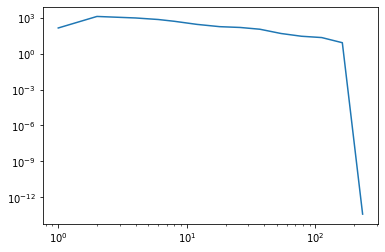

In [12]:
plt.plot(n_iters[:16], diff[:16])
plt.xscale('log')
plt.yscale('log')

In [16]:
np.linalg.norm(X_reproj)

242.43922980249778

In [14]:
m = DebiasingKPCA(n_components=3, kernel=lambda X, Y: TorchRBF(X, Y, gamma=0.14))
m.fit(X, X_index)
X_tmp = m.debias(X[:200], n_iter=200, lr=3./200)

In [15]:
np.linalg.norm(X_reproj - X_tmp)

3.3306590405383755e-14

In [27]:
m = DebiasingKPCA(n_components=3, kernel=lambda X, Y: TorchRBF(X, Y, gamma=0.14))
m.fit(X, X_index)
X_tmp = m.debias(X[:200], n_iter=30, lr=0.01)

In [28]:
np.linalg.norm(X_reproj - X_tmp)

3.283593330656092e-14

In [17]:
m = DebiasingKPCA(n_components=3, kernel=lambda X, Y: TorchRBF(X, Y, gamma=0.14))
m.fit(X, X_index)
X_tmp = m.debias(X[:200], n_iter=100, lr=3./100)

In [18]:
np.linalg.norm(X_reproj - X_tmp)

22.00020749348541